# Deep Reinforcement Learning for Robotic Systems 

## Synopsis

This notebook outlines the modelling and integration of the [Proximal Policy Optimisation](http://arxiv.org/abs/1707.06347) algorithm on an **inverted double pendulum** as a baseline study into advanced astrodynamical control systems, such as docking and berthing of spacecraft, and rocket initialisation stabilisation. 

--------

Produced by *Mughees Asif*, under supervision of [Dr. Angadh Nanjangud](https://www.sems.qmul.ac.uk/staff/a.nanjangud) (Lecturer in Aerospace/Spacecraft Engineering @ [Queen Mary, University of London](https://www.sems.qmul.ac.uk/)).



## 1. <u>Overview</u>

Proximal Policy Optimisation is a deep reinforcement learning algorithm developed by [OpenAI](https://spinningup.openai.com/en/latest/algorithms/ppo.html). It has proven to be successful in a variety of tasks ranging from enabling robotic systems in complex environments, to developing proficiency in computer gaming by using stochastic mathematical modelling to simulate real-life decision making. For the purposes of this research, the algorithm will be implemented to vertically stablise an inverted double pendulum, which is widely used in industry as a benchmark to validate the veracity of next-generation intelligent algorithms.

## 2. <u>Model description</u>

An inverted double pendulum is a characteristic example of a simple-to-build, non-linear, and chaotic mechanical system that has been widely studied in the fields of Robotics, Aerospace, Biomedical, Mechanical Engineering, and Mathematical Analysis.

<img src="images/dip_fbd.png" width="500" />

## 3. <u>Variables</u>

<img src="images/variables.png" width="500" />

## 4. <u>Governing equations of motion</u>

The following section utilises the [SymPy](https://www.sympy.org/en/index.html) package to derive the governing equations of motion. 

### 4.1. Basic modelling

<img src="images/dip_fbd_radius.png" width="400" />

In [47]:
import sympy

# initiliase variables
t = sympy.symbols('t')        # time
m = sympy.symbols('m')        # mass of the cart
l = sympy.symbols('l')        # length of the pendulums, l_1 = l_2 = l
M = sympy.symbols('M')        # mass of the pendulums, M_1 = M_2 = M
I = sympy.symbols('I')        # moment of inertia
g = sympy.symbols('g')        # gravitational constant, 9.81 m/s^2
F = sympy.symbols('F')        # force applied to the cart

x = sympy.Function('x')(t)    # |
Θ = sympy.Function('Θ')(t)    # | --- functions of (t)
Φ = sympy.Function('Φ')(t)    # |

# pendulum(s) 
x_1 = x + (l*sympy.sin(Θ))    # | --- position
x_2 = l*sympy.cos(Θ)          # | 

v = sympy.sqrt(sympy.simplify(v_1.diff(t)**2 + y2.diff(t)**2))         # |  
v_1 = x_1 + l*sympy.sin(Φ)                                             # | --- x, y component of velocity
v_2 = x_2 + l*sympy.cos(Φ)                                             # | 
v_total = sympy.sqrt(sympy.simplify(v_1.diff(t)**2 + v_2.diff(t)**2))  # |

# cart
x_dot = x.diff(t)      # velocity

### 4.2. Kinetic and Potential Energy

In [36]:
# kinetic energy 
Θ_dot = Θ.diff(t)
Φ_dot = Φ.diff(t)

K = 0.5*((m*x_dot**2) + M*(v_1**2 + v_2**2) + I*(Θ_dot**2 + Φ_dot**2))

# potential energy 
P = M*g*l*(2*sympy.cos(Θ) + sympy.cos(Φ))

The kinetic energy, K, of the system: 


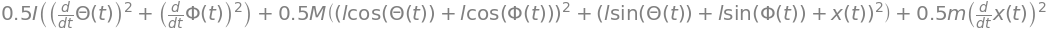

In [35]:
print('The kinetic energy, K, of the system: ')
K

In [37]:
print('The potential energy, P, of the system: ')
P

The potential energy, P, of the system: 


### 4.3. The Lagrangian

The action $S$ of the cart (movement; left, right) is mathematically defined as:

$$S = \int_{t_{0}}^{t_{1}} K - P \,dt$$

since, 

$$L = K - P$$

$$\therefore S = \int_{t_{0}}^{t_{1}} L \,dt$$

The Lagrangian of the system is: 


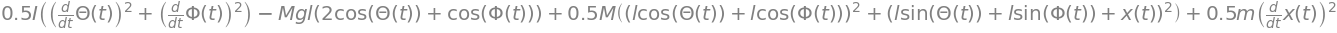

In [43]:
# the lagrangian
L = K - P

print('The Lagrangian of the system is: ')
L

### 4.4. The Euler-Lagrange equations

The standard [Euler-Lagrange equation](https://www.ucl.ac.uk/~ucahmto/latex_html/chapter2_latex2html/node5.html) is:

$$\dfrac{d}{dt}\dfrac{\partial L}{\partial \dot{x}} - \dfrac{\partial L}{\partial x} = 0$$

To introduce the generalised force acting on the cart, the [Lagrange-D'Alembert Principle](https://phys.libretexts.org/Bookshelves/Classical_Mechanics/Book%3A_Variational_Principles_in_Classical_Mechanics_(Cline)/06%3A_Lagrangian_Dynamics/6.03%3A_Lagrange_Equations_from_dAlemberts_Principle) is used:

$$\dfrac{d}{dt}\dfrac{\partial L}{\partial \dot{x}} - \dfrac{\partial L}{\partial x} = Q^{P}$$

Therefore, for a three-dimensional _working_ system, the equations of motion can be derived as:

$$\dfrac{d}{dt}\dfrac{\partial L}{\partial \dot{x}} - \dfrac{\partial L}{\partial x} = F - \dot x$$

$$\dfrac{d}{dt}\dfrac{\partial L}{\partial \dot{\theta}} - \dfrac{\partial L}{\partial \theta} = 0$$

$$\dfrac{d}{dt}\dfrac{\partial L}{\partial \dot{\phi}} - \dfrac{\partial L}{\partial \phi} = 0$$

The Euler-Lagrange equations:
1.


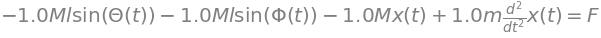

In [55]:
# euler-lagrange
euler_1 = sympy.Eq((L.diff(x.diff(t)).diff(t) - L.diff(x)).simplify().expand().collect(x.diff(t, t)), F)
euler_2 = sympy.Eq((L.diff(Θ.diff(t)).diff(t) - L.diff(Θ)).simplify().expand().collect(Θ.diff(t, t)), 0)
euler_3 = sympy.Eq((L.diff(Φ.diff(t)).diff(t) - L.diff(Φ)).simplify().expand().collect(Φ.diff(t, t)), 0)

print('The Euler-Lagrange equations:\n1.')
euler_1

2.


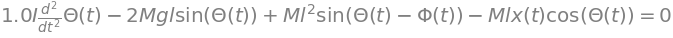

In [51]:
print('2.')
euler_2

3.


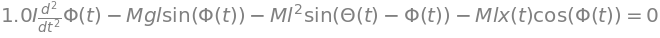

In [52]:
print('3.')
euler_3

### 4.5. Linearisation